In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import os
from pprint import pprint
from dotenv import load_dotenv
load_dotenv()

import nest_asyncio
nest_asyncio.apply()

from llama_index.core import (
    VectorStoreIndex,
    load_index_from_storage,
    StorageContext,
    Settings
)
from llama_index.readers.github import GithubRepositoryReader, GithubClient
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.anthropic import Anthropic
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.node_parser import CodeSplitter
from llama_index.core.agent import ReActAgent, StructuredPlannerAgent, FunctionCallingAgentWorker
from llama_index.tools.code_interpreter.base import CodeInterpreterToolSpec

from IPython.display import Markdown, display

In [3]:
Settings.llm = Anthropic(model='claude-3-5-sonnet-20240620', max_tokens=2048)
Settings.embed_model = OpenAIEmbedding(model="text-embedding-ada-002")

In [4]:
persist_dir = "./storage/matplotlib_galleries"

In [5]:
def parse_matplotlib_galleries():
    github_token = os.environ.get("GITHUB_TOKEN")
    owner = "matplotlib"
    repo = "matplotlib"
    branch = "main"

    github_client = GithubClient(github_token=github_token, verbose=True)

    return GithubRepositoryReader(
        github_client=github_client,
        owner=owner,
        repo=repo,
        use_parser=False,
        verbose=False,
        filter_directories=(
            ["galleries"],
            GithubRepositoryReader.FilterType.INCLUDE,
        ),
        filter_file_extensions=(
            [
                ".py",
            ],
            GithubRepositoryReader.FilterType.INCLUDE,
        ),
    ).load_data(branch=branch)

In [6]:
if not os.path.exists(persist_dir):
    # parse repo
    documents = parse_matplotlib_galleries()
    # build vector index
    node_parser = CodeSplitter('python') # NOTE: I EDITED THE SOURCE IN THIS ENV TO PROPERLY LOAD THE PYTHON PARSER
    nodes = node_parser.get_nodes_from_documents(documents)
    vector_index = VectorStoreIndex(nodes)
    vector_index.storage_context.persist(
        persist_dir=persist_dir
    )
else:
    vector_index = load_index_from_storage(
        StorageContext.from_defaults(persist_dir=persist_dir),
    )

In [7]:
vector_query_engine = vector_index.as_query_engine(llm=Settings.llm, similarity_top_k=10)


In [8]:
tools = [
    QueryEngineTool(
        query_engine=vector_query_engine,
        metadata=ToolMetadata(
            name="vector_tool",
            description="This tool can query the matplotlib gallery examples.",
        ),
    ),
] + CodeInterpreterToolSpec().to_tool_list()

# build agent
function_llm = Anthropic(model="claude-3-5-sonnet-20240620", max_tokens=2048)
tool_agent = FunctionCallingAgentWorker.from_tools(
    tools,
    llm=function_llm,
    verbose=True
)

agent = StructuredPlannerAgent(
    tool_agent, tools=tools, verbose=True
)

In [32]:
pprint({'code': '\nimport os\nimport csv\n\n# Define the unique directory path\nunique_dir = \'/Users/loyalshababo/dev/plotreader/sandbox/storage/plotgen_output/opsin_data_20240911_152739\'\n\n# Define the questions and answers\nqa_data = [\n    [\'question\', \'answer\'],\n    [\'What is the exact difference in peak wavelength sensitivity between the wild-type and mutant opsins?\', \'56.57 nm (Mutant peak at 547.98 nm - Wild-type peak at 491.41 nm)\'],\n    [\'At what specific wavelength do the wild-type and mutant opsin currents intersect?\', \'378.28 nm\'],\n    [\'What is the precise difference in Full Width at Half Maximum (FWHM) between the wild-type and mutant opsin response curves?\', \'31.81 nm (Mutant FWHM of 144.95 nm - Wild-type FWHM of 113.14 nm)\']\n]\n\n# Save questions and answers to a CSV file\nqa_file_path = os.path.join(unique_dir, \'questions_and_answers.csv\')\nwith open(qa_file_path, \'w\', newline=\'\') as file:\n    writer = csv.writer(file)\n    writer.writerows(qa_data)\n\nprint(f"Questions and answers saved to: {qa_file_path}")\n\n# Verify all required files exist\nrequired_files = [\'opsin_current_data.csv\', \'refined_opsin_current_measurements.png\', \'questions_and_answers.csv\']\nfor file in required_files:\n    file_path = os.path.join(unique_dir, file)\n    if os.path.exists(file_path):\n        print(f"File \'{file}\' exists in the unique directory.")\n    else:\n        print(f"Error: File \'{file}\' does not exist in the unique directory.")\n'})

{'code': '\n'
         'import os\n'
         'import csv\n'
         '\n'
         '# Define the unique directory path\n'
         'unique_dir = '
         "'/Users/loyalshababo/dev/plotreader/sandbox/storage/plotgen_output/opsin_data_20240911_152739'\n"
         '\n'
         '# Define the questions and answers\n'
         'qa_data = [\n'
         "    ['question', 'answer'],\n"
         "    ['What is the exact difference in peak wavelength sensitivity "
         "between the wild-type and mutant opsins?', '56.57 nm (Mutant peak at "
         "547.98 nm - Wild-type peak at 491.41 nm)'],\n"
         "    ['At what specific wavelength do the wild-type and mutant opsin "
         "currents intersect?', '378.28 nm'],\n"
         "    ['What is the precise difference in Full Width at Half Maximum "
         "(FWHM) between the wild-type and mutant opsin response curves?', "
         "'31.81 nm (Mutant FWHM of 144.95 nm - Wild-type FWHM of 113.14 "
         "nm)']\n"
         ']\n'
      

In [9]:
response = agent.query(
    f"""
    Use Python to generate some data and then use Matplotlib to generate a plot from it. When you are asked to save files, make sure they are in a unique drectory in `./storage/plotgen_output`. \
    First, you want to make up some scenario and data that is represented in the plot. This should be saved in a CSV. \
    Then you want to plot this data using Matplotlib, but don't put quantitative labels on the plot if they are already available visually. The plots should have the same amount of labeling you'd expect in an academic paper. Save the figure as a PNG. \
    Lastly, write three quantitative questions that could only be answered if the responder was able to know the values in the JSON object but only had access to the plot. Save these questions and answers in a CSV file where the columns are `question` and `answer`. \
    Don't forget that the files are in a unique drectory in `./storage/plotgen_output`.
    """
)

=== Initial plan ===
create_directory:
Create a unique directory in ./storage/plotgen_output -> A unique directory path
deps: []


generate_scenario_data:
Generate a scenario and create corresponding data -> A description of the scenario and a pandas DataFrame with the generated data
deps: ['create_directory']


save_data_to_csv:
Save the generated data to a CSV file in the unique directory -> Confirmation that the CSV file has been saved
deps: ['generate_scenario_data']


create_matplotlib_plot:
Create a Matplotlib plot using the generated data -> A Matplotlib figure object
deps: ['generate_scenario_data']


save_plot_as_png:
Save the Matplotlib plot as a PNG file in the unique directory -> Confirmation that the PNG file has been saved
deps: ['create_matplotlib_plot']


generate_questions_and_answers:
Generate three quantitative questions and answers based on the data -> A list of three questions and their corresponding answers
deps: ['generate_scenario_data']


save_questions_to_csv:

KeyError: 'code_interpreter'

In [10]:
agent.state

PlannerAgentState(task_dict={}, plan_dict={}, completed_sub_tasks={})

In [97]:
display(Markdown(f"{response}"))

Certainly! I'll combine all the previous steps into a single Python function that takes no inputs and returns the required tuple containing the figure handle and the JSON data structure. Here's the complete function:

```python
import matplotlib.pyplot as plt

def create_coffee_consumption_plot():
    # JSON data structure
    data = {
        "title": "Average Daily Coffee Consumption by Profession",
        "x_axis_label": "Profession",
        "y_axis_label": "Average Cups of Coffee per Day",
        "data": [
            {"profession": "Software Developer", "coffee_cups": 3.2},
            {"profession": "Teacher", "coffee_cups": 2.8},
            {"profession": "Nurse", "coffee_cups": 3.7},
            {"profession": "Accountant", "coffee_cups": 2.5},
            {"profession": "Sales Representative", "coffee_cups": 3.9},
            {"profession": "Lawyer", "coffee_cups": 3.4},
            {"profession": "Graphic Designer", "coffee_cups": 2.6}
        ]
    }

    # Extract data from JSON
    professions = [item['profession'] for item in data['data']]
    coffee_cups = [item['coffee_cups'] for item in data['data']]

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(professions, coffee_cups)

    # Customize the plot
    ax.set_xlabel(data['x_axis_label'])
    ax.set_ylabel(data['y_axis_label'])
    ax.set_title(data['title'])

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Add value labels on top of each bar
    ax.bar_label(bars, fmt='%.1f')

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    return fig, data

# Usage example:
# fig, json_data = create_coffee_consumption_plot()
# plt.show()  # If you want to display the plot
```

This function `create_coffee_consumption_plot()` does the following:

1. Defines the JSON data structure within the function, containing the coffee consumption data by profession.
2. Extracts the necessary data from the JSON structure to create the plot.
3. Creates a bar plot using Matplotlib, with customizations such as:
   - Setting appropriate labels and title
   - Rotating x-axis labels for better readability
   - Adding value labels on top of each bar
   - Adjusting the layout to prevent label clipping
4. Returns a tuple containing:
   - The figure handle (`fig`)
   - The original JSON data structure (`data`)

To use this function, you would simply call it without any arguments:

```python
fig, json_data = create_coffee_consumption_plot()
plt.show()  # If you want to display the plot
```

This function encapsulates all the steps we've discussed earlier:
- Creating the scenario and corresponding data (stored in the JSON structure)
- Using that data to create a Matplotlib bar plot
- Returning both the figure handle and the initial JSON data structure

The function requires no inputs, making it self-contained and easy to use. It provides both the visualization (via the figure handle) and easy access to the underlying data structure (via the returned JSON data).

/var/folders/0w/7p0llwyd0n39my8_dt311mtr0000gn/T/ipykernel_73307/59183866.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


{"Espresso": 58, "Latte": 175, "Cappuccino": 109, "Americano": 140, "Mocha": 95}


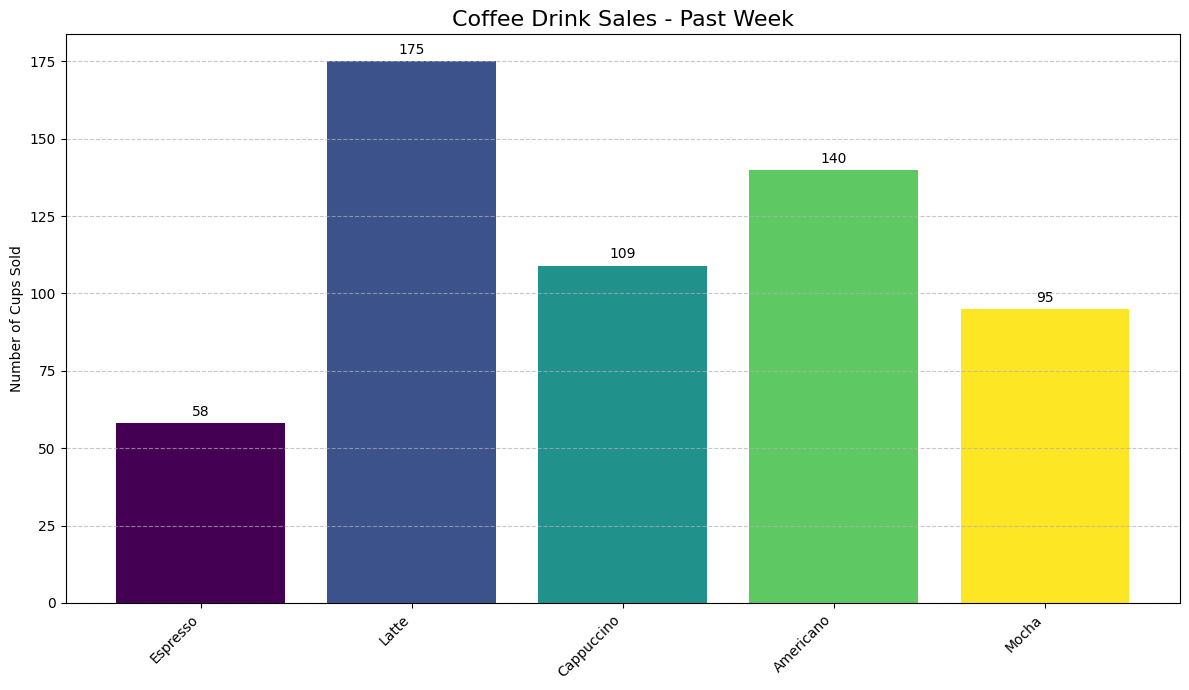

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.cm import get_cmap

def generate_coffee_sales_plot():
    # Set a consistent style
    # Coffee drink data
    drinks = ['Espresso', 'Latte', 'Cappuccino', 'Americano', 'Mocha']
    
    # Generate random sales data using NumPy (between 50 and 250 cups for each drink)
    sales = np.random.randint(50, 251, size=len(drinks))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Use a colormap for consistent and visually appealing colors
    cmap = get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(drinks)))
    
    y_pos = np.arange(len(drinks))
    bars = ax.bar(y_pos, sales, align='center', color=colors)
    
    # Add value labels on top of each bar
    ax.bar_label(bars, padding=3)
    
    # Customize the plot
    ax.set_xticks(y_pos)
    ax.set_xticklabels(drinks, rotation=45, ha='right')
    ax.set_ylabel('Number of Cups Sold')
    ax.set_title('Coffee Drink Sales - Past Week', fontsize=16)
    
    # Add a grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout and display
    plt.tight_layout()
    
    # Prepare JSON data using dictionary comprehension
    json_data = json.dumps({drink: int(sale) for drink, sale in zip(drinks, sales)})
    
    return fig, json_data

# Example usage:
fig, json_data = generate_coffee_sales_plot()
print(json_data)
plt.show()

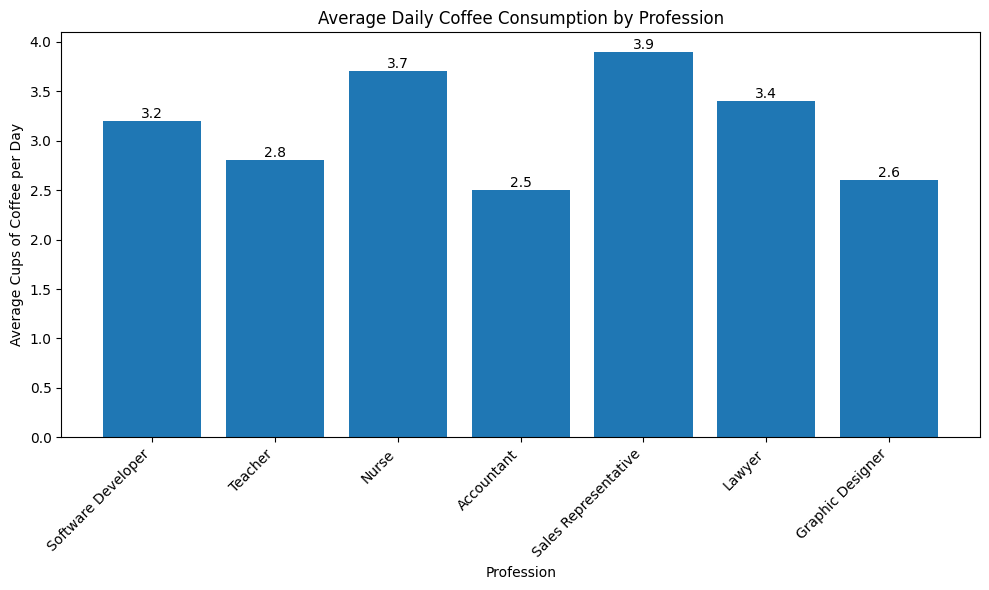

In [99]:
import matplotlib.pyplot as plt

def create_coffee_consumption_plot():
    # JSON data structure
    data = {
        "title": "Average Daily Coffee Consumption by Profession",
        "x_axis_label": "Profession",
        "y_axis_label": "Average Cups of Coffee per Day",
        "data": [
            {"profession": "Software Developer", "coffee_cups": 3.2},
            {"profession": "Teacher", "coffee_cups": 2.8},
            {"profession": "Nurse", "coffee_cups": 3.7},
            {"profession": "Accountant", "coffee_cups": 2.5},
            {"profession": "Sales Representative", "coffee_cups": 3.9},
            {"profession": "Lawyer", "coffee_cups": 3.4},
            {"profession": "Graphic Designer", "coffee_cups": 2.6}
        ]
    }

    # Extract data from JSON
    professions = [item['profession'] for item in data['data']]
    coffee_cups = [item['coffee_cups'] for item in data['data']]

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(professions, coffee_cups)

    # Customize the plot
    ax.set_xlabel(data['x_axis_label'])
    ax.set_ylabel(data['y_axis_label'])
    ax.set_title(data['title'])

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Add value labels on top of each bar
    ax.bar_label(bars, fmt='%.1f')

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    return fig, data

# Usage example:
fig, json_data = create_coffee_consumption_plot()
plt.show()  # If you want to display the plot


In [15]:
 _PROMPT = """
                Use Python to generate some data and then use Matplotlib to generate a plot from it. 
                When you are asked to save files, make sure they are in a unique directory in {output_dir}. 
                First, you want to make up some scenario and data that is represented in the plot. This should be saved in a CSV. 
                Then you want to plot this data using Matplotlib, but don't put quantitative labels on the plot if they are already available visually. The plots should have the same amount of labeling you'd expect in an academic paper. Save the figure as a PNG. 
                Lastly, write three quantitative questions that could only be answered if the responder was able to know the values in the JSON object but only had access to the plot. Save these questions and answers in a CSV file where the columns are `question` and `answer`. 
                Don't forget that the files are in a unique drectory in `./storage/plotgen_output`.
            """

In [16]:
_PROMPT.format(output_dir = 'foo')

"\n               Use Python to generate some data and then use Matplotlib to generate a plot from it. \n               When you are asked to save files, make sure they are in a unique directory in foo. \n               First, you want to make up some scenario and data that is represented in the plot. This should be saved in a CSV. \n               Then you want to plot this data using Matplotlib, but don't put quantitative labels on the plot if they are already available visually. The plots should have the same amount of labeling you'd expect in an academic paper. Save the figure as a PNG. \n               Lastly, write three quantitative questions that could only be answered if the responder was able to know the values in the JSON object but only had access to the plot. Save these questions and answers in a CSV file where the columns are `question` and `answer`. \n               Don't forget that the files are in a unique drectory in `./storage/plotgen_output`.\n           "